In [1]:
%run env_setup.py
%matplotlib inline
import os
from importlib import reload

In [2]:
import lessdeep as ld
import numpy as np

In [3]:
img_file = ld.utils.download_file('http://farm2.static.flickr.com/1422/987713710_f801e72921.jpg')

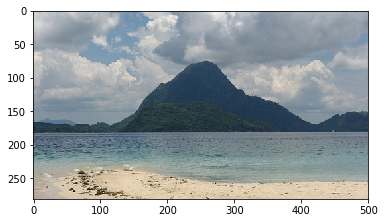

In [4]:
from matplotlib import pyplot as plt
from PIL import Image
img = np.array(Image.open(img_file), dtype=np.float32)
plt.imshow(img.astype(np.uint8))
plt.show()

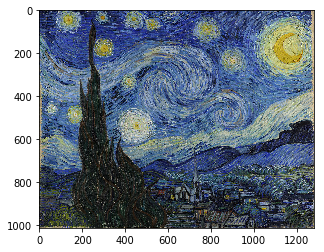

In [5]:
van_img = Image.open(ld.utils.download_file('https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1280px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg'))
van_img = np.array(van_img, dtype=np.float32)
plt.imshow(van_img.astype(np.uint8))
plt.show()

In [6]:
%pdb

Automatic pdb calling has been turned ON


In [7]:
from lessdeep.model.vgg16n import Vgg16N
import keras

vgg_avg=Vgg16N(include_top=False)
vgg_avg_layers = []
for l in vgg_avg.model.layers:
    if isinstance(l, keras.layers.MaxPool2D):
        vgg_avg_layers.append(keras.layers.AveragePooling2D((2, 2), strides=(2, 2)))
    else:
        vgg_avg_layers.append(l)
vgg_avg.model = ld.utils.clone_model(vgg_avg_layers)
vgg_avg.compile()
vgg_avg.model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 64)    1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 64)    36928     
_________________________________________________________________
average_pooling2d_5 (Average (None, None, None, 64)    0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 128)   73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, None, None, 128)   147584    
_________________________________________________________________
average_pooling2d_6 (Average (None, None, None, 128)   0         
__________

In [8]:
conv_idx = [i for i, l in enumerate(vgg_avg.model.layers) if isinstance(l, keras.layers.Conv2D)]

In [9]:
conv_idx

[1, 2, 4, 5, 7, 8, 9, 11, 12, 13, 15, 16, 17]

In [10]:
from keras.applications.imagenet_utils import preprocess_input
img_input = preprocess_input(img)[None]
van_img_input = preprocess_input(van_img)[None]

In [11]:
import keras.backend as K
def reverse_input(x):
    data_format = K.image_data_format()
    if data_format == 'channels_first':
        if x.ndim == 3:
            # 'BGR'->'RGB'
            x = x[::-1, ...]
            # Zero-center by mean pixel
            x[0, :, :] += 123.68
            x[1, :, :] += 116.779
            x[2, :, :] += 103.939
        else:
            x = x[:, ::-1, ...]
            x[:, 0, :, :] += 123.68
            x[:, 1, :, :] += 116.779
            x[:, 2, :, :] += 103.939
    else:
        # 'BGR'->'RGB'
        x = x[..., ::-1]
        # Zero-center by mean pixel
        x[..., 0] += 123.68
        x[..., 1] += 116.779
        x[..., 2] += 103.939
    return x

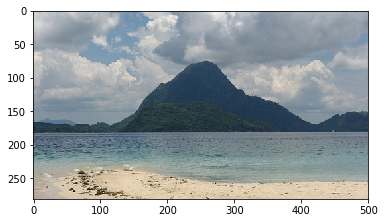

In [12]:
plt.imshow(reverse_input(img_input[0]).astype(np.uint8))
plt.show()

In [13]:
layer = vgg_avg.model.layers[conv_idx[-3]].output
layer_model = keras.Model(vgg_avg.model.input, layer)

In [14]:
tgt = K.variable(layer_model.predict(img_input))

In [15]:
loss = keras.metrics.mse(tgt, layer)
grad = K.gradients(loss, vgg_avg.model.input)

In [28]:
class Runner(object):
    def __init__(self, f, in_shape):
        self._f, self.shape = f, in_shape
    def loss(self, x):
        loss, self._grad = self._f([x.reshape(self.shape)])
        return loss.astype(np.float64)
    def grad(self, x):
        return self._grad.astype(np.float64).flatten()
runner = Runner(K.function([vgg_avg.model.input], [loss]+grad), img_input.shape)

In [17]:
from scipy.optimize import fmin_l_bfgs_b

def learn_image(run_obj, x, niter):
    his = []
    for i in range(niter):
        x, f, d = fmin_l_bfgs_b(run_obj.loss, x.flatten(), fprime=run_obj.grad, maxiter=20)
        his.append(x.reshape(run_obj.shape).copy())
        print('Iter {0}: loss {1}'.format(i, f))
    return his

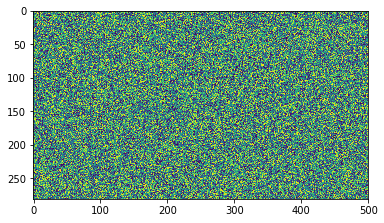

In [29]:
rand_img = np.array(np.random.uniform(-2.5, 2.5, img_input.shape).astype(np.float32)/100)
#rand_img[0]
import matplotlib
plt.imshow(rand_img[0][:,:,0])
plt.show()

In [30]:
his = learn_image(runner, rand_img, niter=10)

KeyboardInterrupt: 

In [19]:
%pdb

Automatic pdb calling has been turned OFF


In [24]:
%matplotlib inline